In [1]:
from prody import *
import numpy as np
import spcoords
from math import log10, floor, sqrt
def round_sig(x, sig=2):
    return round(x,sig-int(floor(log10(x)))-1)

### Fetch initial structure and iterpose

In [2]:
pdb = parsePDB("initial.pdb")
ensemble_cov_2 = parseDCD("initial.dcd")
structure_calpha = pdb.select("calpha")
residue_number = len(structure_calpha)
ensemble_length = len(ensemble_cov_2)
ensemble_cov_2_mean_ref = (ensemble_cov_2.getCoordsets()).mean(0)
ensemble_cov_2.setAtoms(structure_calpha);
ensemble_cov_2_mean = (ensemble_cov_2.getCoordsets()).mean(0)
ensemble_cov_2.setCoords(ensemble_cov_2_mean_ref);
ensemble_cov_2.iterpose(rmsd=0.00001);

@> 143 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> DCD file contains 2002 coordinate sets for 143 atoms.
@> DCD file was parsed in 0.00 seconds.
@> 3.43 MB parsed at input rate 687.72 MB/s.
@> 2002 coordinate sets parsed at input rate 401520 frame/s.
@> Starting iterative superposition:
@> Step #1: RMSD difference = 2.4608e-02
@> Step #2: RMSD difference = 1.2488e-04
@> Step #3: RMSD difference = 7.4790e-06
@> Iterative superposition completed in 2.48s.


### RMSD Plot of Mean

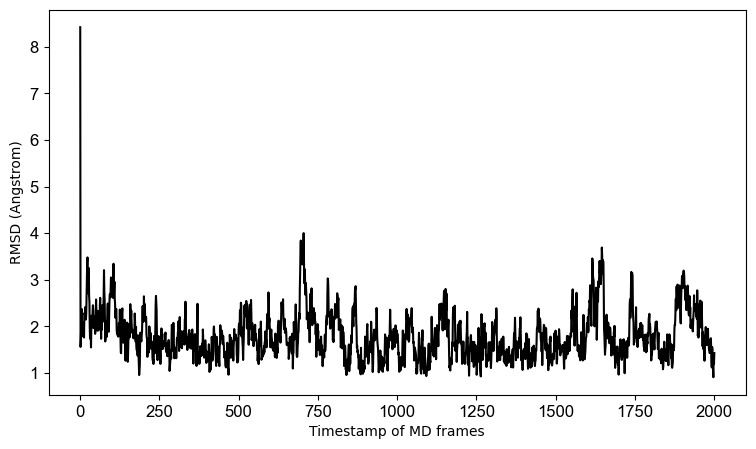

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm

RMSD = ensemble_cov_2.getRMSDs()
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('RMSD (Angstrom)'); #set label names
ax.set_xlabel('Timestamp of MD frames');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(RMSD, color="black")
#ax.errorbar(residues, BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()
np.savetxt("rmsd_apo_deneme.dat", RMSD)

### Creation Displacement Vector

In [4]:
R_mat = np.zeros((ensemble_length, residue_number, 3))


In [5]:
ensemble_cov_2_coors = (ensemble_cov_2.getCoordsets())


In [6]:
ensemble_cov_2_coors.shape

(2002, 143, 3)

In [7]:
ensemble_cov_2_mean.shape

(143, 3)

In [8]:
for i in range(ensemble_length):
    R_mat[i, :, :] = ensemble_cov_2_coors[i, :, :] - ensemble_cov_2_mean
    

In [9]:
R_mat[0, 0, :]

array([-17.70233536,   1.64832306,   0.71349335])

In [10]:
f_mat = R_mat.reshape(ensemble_length, residue_number*3).T
s_mat = R_mat.reshape(ensemble_length, residue_number*3)


In [11]:
cov_mat = np.divide(np.matmul(f_mat,s_mat), ensemble_length-1)


### Covariance Matrix

In [12]:
nump_cov = np.cov(ensemble_cov_2_coors.reshape(ensemble_length, residue_number*3).T)[0]


In [13]:
np.sum(nump_cov-cov_mat)


-0.002511727193629909

### Creation of final(target) structure and R*

In [14]:
initial = structure_calpha.getCoords()
final = parsePDB("final.pdb").getCoords()
final_alg = spcoords.superposer(final, initial)
diffE = (final_alg[0]-initial).reshape(residue_number*3, 1)


@> 143 atoms and 1 coordinate set(s) were parsed in 0.00s.


### Perturb & Overlap
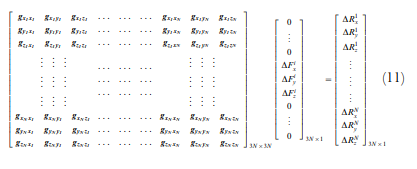

In [15]:
perturbations = 200
diffP = np.zeros((residue_number, residue_number*3, perturbations))
initial_trans = initial.reshape(1, residue_number*3)
overlap = np.zeros((residue_number, perturbations))

for s in range(0, perturbations):
    for i in range(0, residue_number):
        delF = np.zeros((residue_number*3))
        f = 2 * np.random.random((3, 1)) - 1
        j = (i + 1) * 3

        delF[j-3] = round_sig(abs(f[0,0]), 5)* -1 if f[0,0]< 0 else round_sig(abs(f[0,0]), 5)
        delF[j-2] = round_sig(abs(f[1,0]), 5)* -1 if f[1,0]< 0 else round_sig(abs(f[1,0]), 5)
        delF[j-1] = round_sig(abs(f[2,0]), 5)* -1 if f[2,0]< 0 else round_sig(abs(f[2,0]), 5)

        diffP[i,:,s] = np.dot((delF), (cov_mat))
        diffP[i,:,s] = diffP[i,:,s] + initial_trans[0]


        diffP[i,:,s] = ((spcoords.superposer(diffP[i,:,s].reshape(residue_number, 3), initial)[0].reshape(1, residue_number*3))[0]) - initial_trans[0]
    
        overlap[i,s] =( np.dot(diffP[i,:,s], diffE))/(np.linalg.norm(diffP[i,:,s],2)*np.linalg.norm(diffE,2))


### Getting Maximum and Average Overlap

In [16]:
#      for i=1:N
#        Maximum(i) = max(abs(overlap(i,:)));
#    end
#    Average =mean(abs(overlap'));
maximum_overlap = np.zeros(residue_number)
for i in range(residue_number):
    maximum_overlap[i] = max(abs(overlap[i,:]))
               
np.savetxt("maximum_overlap.dat",  maximum_overlap)
np.savetxt("avg_overlap.dat",  np.mean(abs(overlap), axis=1))

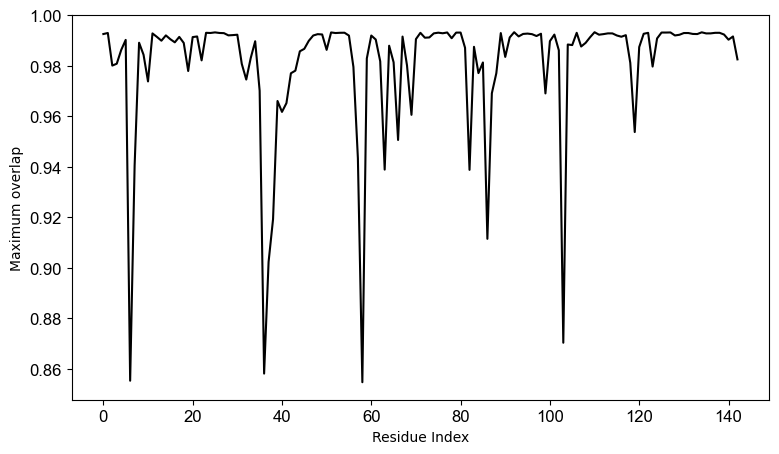

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Maximum overlap'); #set label names
ax.set_xlabel('Residue Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(maximum_overlap, color="black")
#ax.errorbar(residues, BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()

### Correlations between predicted and experimental structures
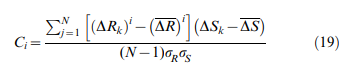

In [18]:
DTarget = np.zeros(residue_number)
DIFF = np.zeros((residue_number, residue_number, perturbations))
RHO = np.zeros((residue_number, perturbations))

for i in range(0, residue_number):
    DTarget[i] = sqrt(diffE[3*(i+1)-3]**2 + diffE[3*(i+1)-2]**2 + diffE[3*(i+1)-1]**2)

for j in range(0, perturbations):
    for i in range(0, residue_number):
        for k in range(0, residue_number):
            DIFF[k,i,j] = sqrt((diffP[i, 3*(k+1)-3, j]**2) + (diffP[i, 3*(k+1)-2, j]**2) + (diffP[i, 3*(k+1)-1, j]**2))


for i in range(0, perturbations):
    for j in range(0, residue_number):
        RHO[j,i] = np.corrcoef(np.transpose(DIFF[:,j,i]), DTarget)[0,1]

maxRHO = np.zeros(residue_number)
for i in range(0, residue_number):
    maxRHO[i] = np.amax(abs(RHO[i,:]))

np.savetxt("corr_coeff.dat", maxRHO)

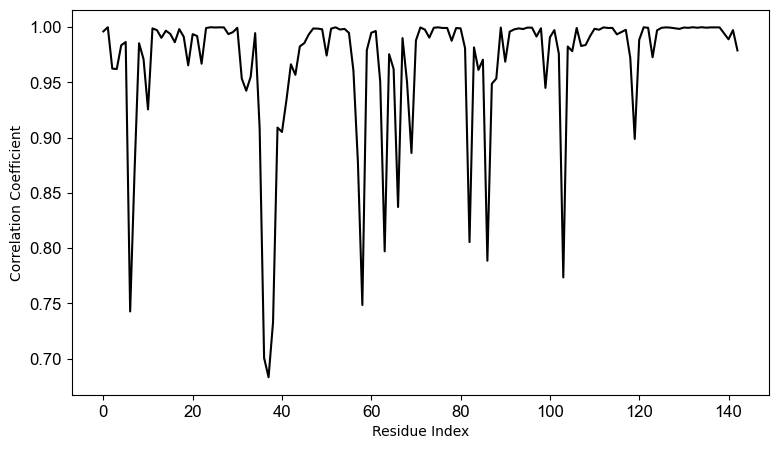

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Correlation Coefficient'); #set label names
ax.set_xlabel('Residue Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(maxRHO, color="black")
#ax.errorbar(residues, BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()

### Calculating with Hessian Matrix

In [20]:
inital_str_ANM = ANM('')
inital_str_ANM.buildHessian(structure_calpha, cutoff=15.0)
hessian= inital_str_ANM.getHessian()
inv_hessian = np.linalg.pinv(hessian, hermitian = True)


@> Hessian was built in 0.05s.


### Inverse Hessian ≌ Covariance Matrix 

In [21]:
inv_hessian = cov_mat
perturbations = 10
diffP = np.zeros((residue_number, residue_number*3, perturbations))
initial_trans = initial.reshape(1, residue_number*3)
overlap = np.zeros((residue_number, perturbations))

for s in range(0, perturbations):
    for i in range(0, residue_number):
        delF = np.zeros((residue_number*3))
        f = 2 * np.random.random((3, 1)) - 1
        j = (i + 1) * 3

        delF[j-3] = round_sig(abs(f[0,0]), 5)* -1 if f[0,0]< 0 else round_sig(abs(f[0,0]), 5)
        delF[j-2] = round_sig(abs(f[1,0]), 5)* -1 if f[1,0]< 0 else round_sig(abs(f[1,0]), 5)
        delF[j-1] = round_sig(abs(f[2,0]), 5)* -1 if f[2,0]< 0 else round_sig(abs(f[2,0]), 5)

        diffP[i,:,s] = np.dot((delF), (cov_mat))
        diffP[i,:,s] = diffP[i,:,s] + initial_trans[0]


        diffP[i,:,s] = ((spcoords.superposer(diffP[i,:,s].reshape(residue_number, 3), initial)[0].reshape(1, residue_number*3))[0]) - initial_trans[0]
        
        overlap[i,s] =( np.dot(diffP[i,:,s], diffE))/(np.linalg.norm(diffP[i,:,s],2)*np.linalg.norm(diffE,2))


In [22]:
#      for i=1:N
#        Maximum(i) = max(abs(overlap(i,:)));
#    end
#    Average =mean(abs(overlap'));
maximum_overlap = np.zeros(residue_number)
for i in range(residue_number):
    maximum_overlap[i] = max(abs(overlap[i,:]))
               
np.savetxt("maximum_overlap_anm.dat",  maximum_overlap)
np.savetxt("avg_overlap_anm.dat",  np.mean(abs(overlap), axis=1))

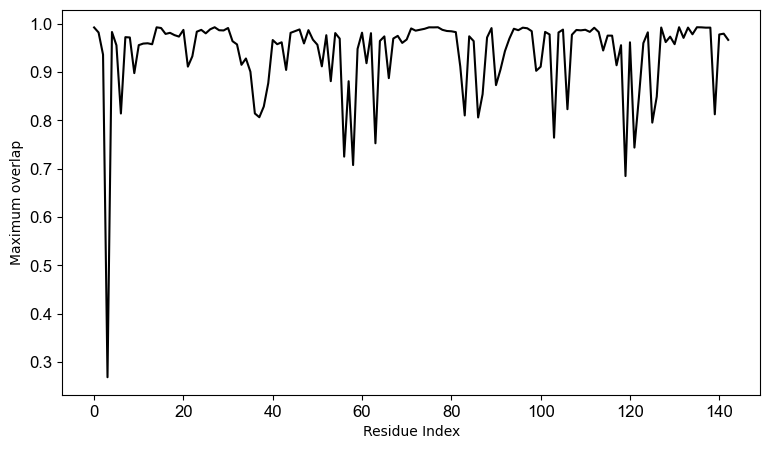

In [23]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Maximum overlap'); #set label names
ax.set_xlabel('Residue Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(maximum_overlap, color="black")
#ax.errorbar(residues, BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()

In [24]:
DTarget = np.zeros(residue_number)
DIFF = np.zeros((residue_number, residue_number, perturbations))
RHO = np.zeros((residue_number, perturbations))

for i in range(0, residue_number):
    DTarget[i] = sqrt(diffE[3*(i+1)-3]**2 + diffE[3*(i+1)-2]**2 + diffE[3*(i+1)-1]**2)

for j in range(0, perturbations):
    for i in range(0, residue_number):
        for k in range(0, residue_number):
            DIFF[k,i,j] = sqrt((diffP[i, 3*(k+1)-3, j]**2) + (diffP[i, 3*(k+1)-2, j]**2) + (diffP[i, 3*(k+1)-1, j]**2))


for i in range(0, perturbations):
    for j in range(0, residue_number):
        RHO[j,i] = np.corrcoef(np.transpose(DIFF[:,j,i]), DTarget)[0,1]

maxRHO = np.zeros(residue_number)
for i in range(0, residue_number):
    maxRHO[i] = np.amax(abs(RHO[i,:]))

np.savetxt("corr_coeff_anm.dat", maxRHO)

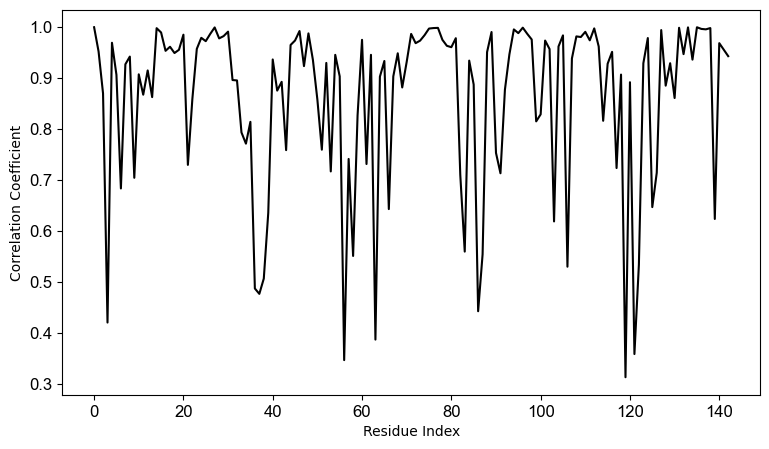

In [25]:
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Correlation Coefficient'); #set label names
ax.set_xlabel('Residue Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.plot(maxRHO, color="black")
#ax.errorbar(residues, BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()